In [1]:
import os
import datetime
import pandas as pd
import pandas_datareader.data as web

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
from sklearn.model_selection import TimeSeriesSplit 
from pmdarima.arima import auto_arima

## Gathering stocks

In [5]:
try:
    ### Local Storage
    apple = pd.read_csv("./data/apple_stock.csv")
except:
    ### Alpha Vantage API
    # os.environ["ALPHA_VANTAGE_API_KEY"] ="0LQY2GPX91HZXOYZ" 
    API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")

    # Define the start date for the data retrieval
    start = datetime.datetime(2023, 1, 1)
    end = datetime.datetime.today()

    apple = web.DataReader("AAPL", "av-daily", start=start, end=end, api_key=API_KEY)
    apple

#### Conclusion
This API is very fast and runs with no errors unlike those we have tried before (yfinance et al.)

## Save

In [6]:
apple.to_csv("./data/apple_stock.csv", index=True)

## Exploration

In [7]:
apple.dtypes

Unnamed: 0     object
open          float64
high          float64
low           float64
close         float64
volume          int64
dtype: object

In [8]:
apple.isna().any()

Unnamed: 0    False
open          False
high          False
low           False
close         False
volume        False
dtype: bool

### Preprocessing

In [9]:
# Making index into date time object
apple.set_index(pd.to_datetime(apple.reset_index().iloc[:,0]), inplace=True)

## Visualization

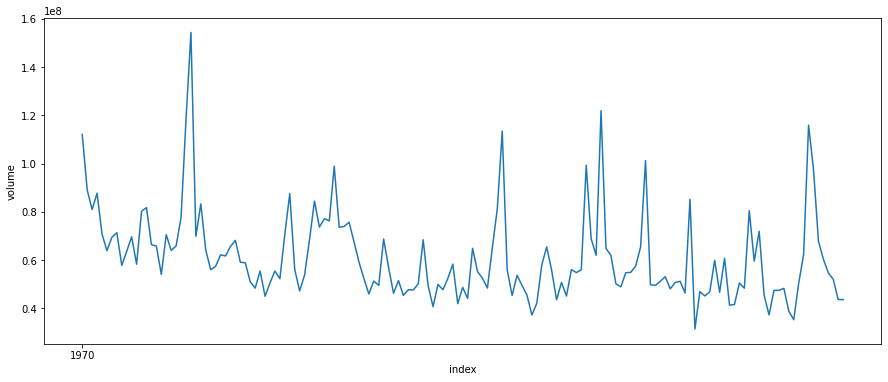

In [10]:
plt.figure(figsize=(15, 6))
sns.lineplot(apple.volume)
plt.show()

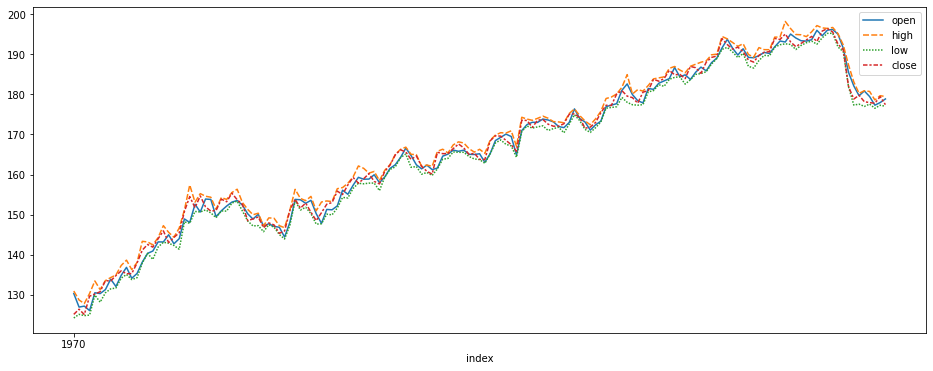

In [11]:
plt.figure(figsize=(16, 6))
sns.lineplot(apple.drop(columns='volume'))
plt.show()

## Stationarity

### Volume
Trade volume seems fairly stationary. Let's test that.

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
adft = adfuller(apple.volume, autolag="AIC")

In [14]:
# Displaying our results as a dataframe
output_df = pd.DataFrame({"Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"], "Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]})
print(output_df)

                        Metric        Values
0              Test Statistics -7.541935e+00
1                      p-value  3.360250e-11
2             No. of lags used  0.000000e+00
3  Number of observations used  1.540000e+02
4          critical value (1%) -3.473543e+00
5          critical value (5%) -2.880498e+00
6         critical value (10%) -2.576878e+00


#### Conclusion
We have strong evidence (p-value << 0.05) against the null hypothesis, so we accept the alternative, that the trading volume series is in fact stationary

## Forecasting (Initial)

In [15]:
tscv = TimeSeriesSplit(n_splits=2, test_size=apple.shape[0]//10)

for train_index, test_index in tscv.split(apple):
    train = apple.iloc[train_index]
    test = apple.iloc[test_index]

### Volume

In [16]:
model = auto_arima(train.volume, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train.volume)

forecast = pd.DataFrame()
forecast['prediction'] = model.predict(n_periods=len(test.volume))
forecast.set_index(test.index, inplace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5017.418, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5051.532, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5035.763, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5025.144, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5049.652, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5019.073, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5022.104, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5018.285, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5020.334, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5018.152, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5023.951, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5012.988, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5

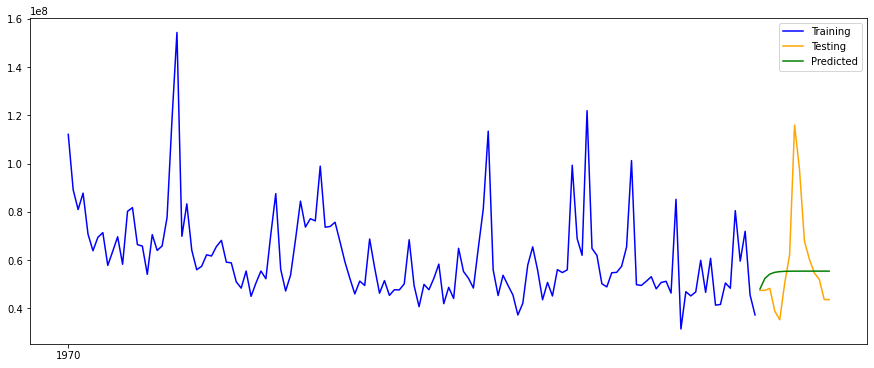

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(train.volume, label="Training", color="blue")
plt.plot(test.volume, label="Testing", color="orange")
plt.plot(forecast, label="Predicted", color="green")
plt.legend(loc='best')
plt.show()

#### Conclusion.
We get a bad prediction. This is most likely because we have not done the proper preprocessing on our data.

### Price
We will use one of the prices since they are roughly the same.

In [18]:
model = auto_arima(train.high, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train.high)

forecast = pd.DataFrame()
forecast['prediction'] = model.predict(n_periods=len(test.high))
forecast.set_index(test.index, inplace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=599.861, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=600.067, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=599.531, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=604.520, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=599.317, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=599.888, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=601.502, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=607.782, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.867 seconds


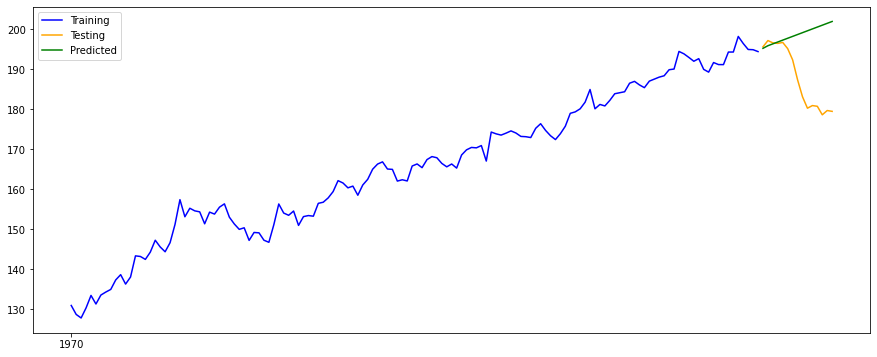

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(train.high, label="Training", color="blue")
plt.plot(test.high, label="Testing", color="orange")
plt.plot(forecast, label="Predicted", color="green")
plt.legend(loc='best')
plt.show()

#### Conclusion
It captures the trend, unable to anticipate the dip. This may be a good reason for detrending the series.

## Decomposition

### Period
Our dataset has daily observations (or at least it should). So in specifying `period=` we are specifying the number of days. We will try meaningful numbers such as 7, 14, 21, 28 for 1, 2, 3, 4 weeks and 30 days for a month.

### Volume

In [20]:
add_decomp_vol = seasonal_decompose(apple.volume, model="additive", period=14)
mult_decomp_vol = seasonal_decompose(apple.volume, model="multiplicative", period=14)

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\seasonal.py:336: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\seasonal.py:336: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\seasonal.py:336: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\seasonal.py:336: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)
C:\U

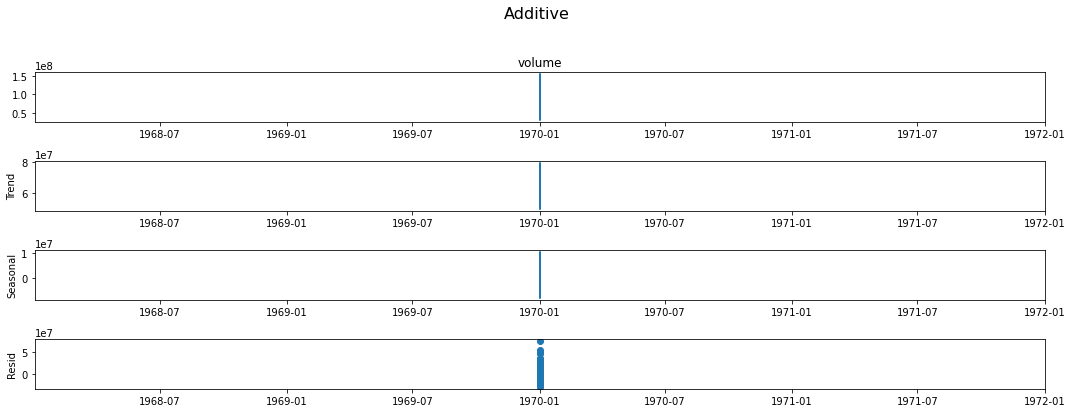

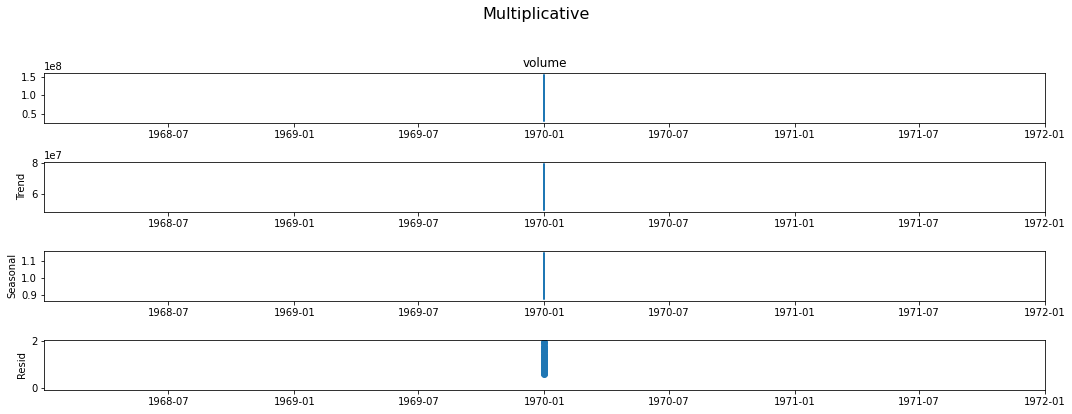

In [21]:
plt.rcParams.update({'figure.figsize' : (15, 6)})
add_decomp_vol.plot().suptitle("Additive", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
mult_decomp_vol.plot().suptitle("Multiplicative", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Intermediate Observations
For the volume series, both multiplicative and additive approaches appear to result in similar decompositions, with differences in the residuals. 

### Price

In [22]:
add_decomp_price = seasonal_decompose(apple.high, model="additive", period=7)
mult_decomp_price = seasonal_decompose(apple.high, model="multiplicative", period=7)

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\seasonal.py:336: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\seasonal.py:336: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\seasonal.py:336: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\seasonal.py:336: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)
C:\U

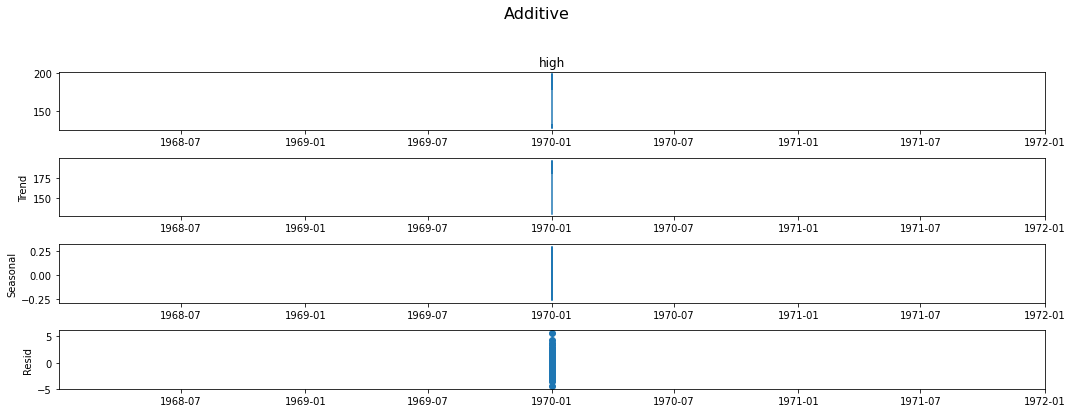

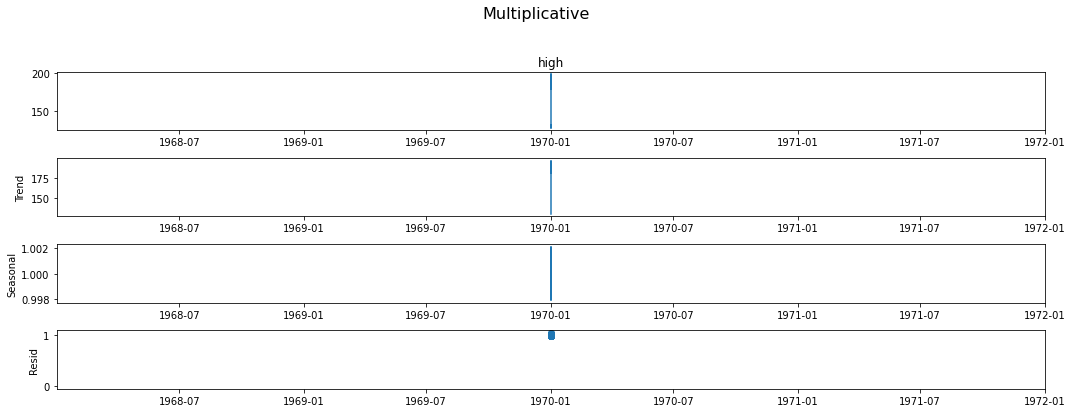

In [23]:
plt.rcParams.update({'figure.figsize' : (15, 6)})
add_decomp_price.plot().suptitle("Additive", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
mult_decomp_price.plot().suptitle("Multiplicative", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Detrending
We will remove the trend component in the series and try to predict on the resulting stationary series.

In [24]:
detrended = apple.high - add_decomp_price.trend
detrended_ = detrended.dropna()

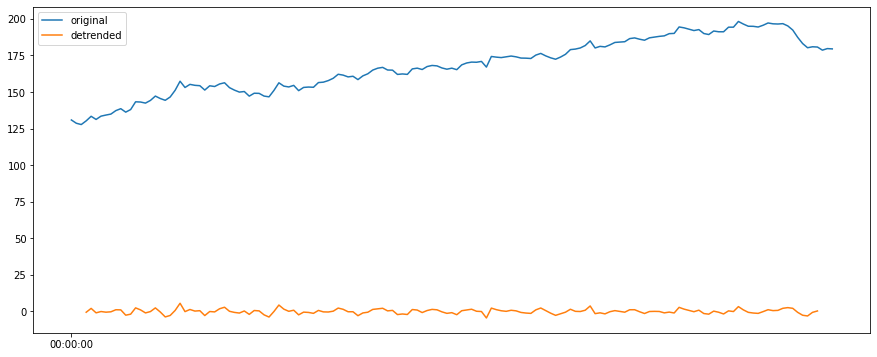

In [25]:
plt.plot(apple.high, label="original")
plt.plot(detrended_, label="detrended")
plt.legend(loc='best')
plt.show()

## Forecasting (Further)

In [73]:
tscv = TimeSeriesSplit(n_splits=2, test_size=detrended_.shape[0]//10)

for train_index, test_index in tscv.split(detrended_):
    train = detrended_.iloc[train_index]
    test = detrended_.iloc[test_index]

In [62]:
model = auto_arima(detrended_, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = pd.DataFrame()
forecast['prediction'] = model.predict(n_periods=len(test))
forecast.set_index(test.index, inplace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=522.989, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=563.858, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=557.045, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=553.643, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=561.898, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=521.114, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=555.625, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=548.303, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=522.981, Time=0.23 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=540.659, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=521.467, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=520.751, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=553.647, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=546.337, 

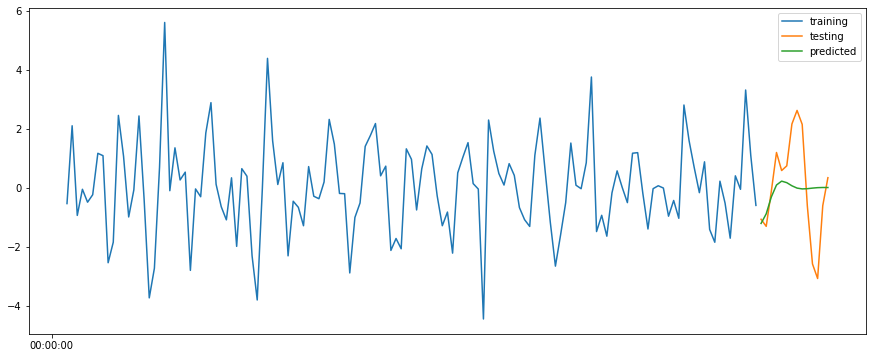

In [63]:
plt.figure(figsize=(15, 6))
plt.plot(train, label="training")
plt.plot(test, label="testing")
plt.plot(forecast, label="predicted")
plt.legend(loc='best')
plt.show()

### Conclusion
It does a little better (based only on visual inspection) but it still fails to capture the pattern in the time series.

### Re-Integrating the Trend

In [74]:
retrended = test + forecast.prediction

In [76]:
print(test.head(2), retrended.head(2))

index
1970-01-01 00:00:00.000000138   -1.070000
1970-01-01 00:00:00.000000139   -1.310857
dtype: float64 index
1970-01-01 00:00:00.000000138   -2.281928
1970-01-01 00:00:00.000000139   -2.197598
dtype: float64


In [65]:
tscv = TimeSeriesSplit(n_splits=2, test_size=apple.shape[0]//10)

for train_index, test_index in tscv.split(apple):
    train = apple.iloc[train_index]
    test = apple.iloc[test_index]

In [66]:
retrended

index
1970-01-01 00:00:00.000000138   -2.281928
1970-01-01 00:00:00.000000139   -2.197598
1970-01-01 00:00:00.000000140   -0.425203
1970-01-01 00:00:00.000000141    1.286639
1970-01-01 00:00:00.000000142    0.805212
1970-01-01 00:00:00.000000143    0.913221
1970-01-01 00:00:00.000000144    2.226983
1970-01-01 00:00:00.000000145    2.608863
1970-01-01 00:00:00.000000146    2.107761
1970-01-01 00:00:00.000000147   -0.651516
1970-01-01 00:00:00.000000148   -2.599127
1970-01-01 00:00:00.000000149   -3.078334
1970-01-01 00:00:00.000000150   -0.601139
1970-01-01 00:00:00.000000151    0.346317
dtype: float64

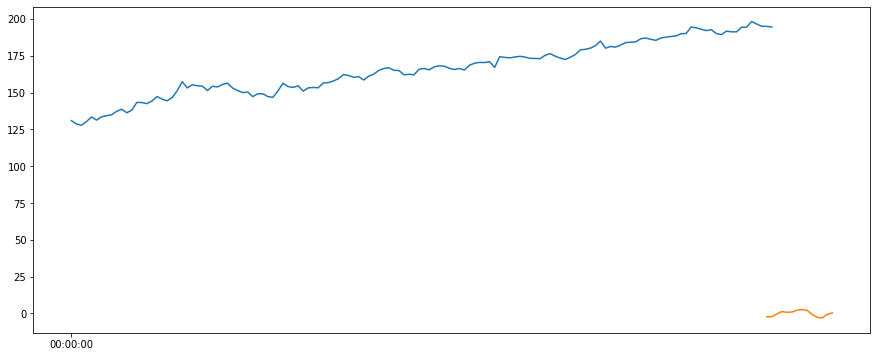

In [67]:
plt.figure(figsize=(15, 6))
plt.plot(train.high, label="Train")
plt.plot(retrended, label="Predicted")
plt.show()

#### Conclusion
We need to add back the trend to the prediction to have proper prediction. This is really hard. So this will need to be revisited.